In [8]:
import numpy as np
import pandas as pd
import glob
import re
from tqdm import tqdm
import os.path
import collections
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:

folder_prompt_ = "../../../data/OpenAI/PromptsAnalysesData/"

file = "caribbean_df_orig_GT.csv"
df_caribbean_GT = pd.read_csv(F"{folder_prompt_}{file}", header=[0, 1], index_col=0)\
    .rename_axis('Species', axis='index')

file = "caribbean_df_orig_ChatGPT.csv"
df_caribbean_ChatGPT = pd.read_csv(F"{folder_prompt_}{file}", header=[0, 1], index_col=0)\
    .rename_axis('Species', axis='index')

In [10]:
df_caribbean_GT

Life form      Leaf position                               \
                        liana tree     alternate alternate, opposite opposite   
Species                                                                         
Bursera karsteniana         0    1             1                   0        0   
Avicennia germinans         0    1             0                   0        1   

                                                                            \
                    opposite, whorls of 3 opposite, whorls of 3, alternate   
Species                                                                      
Bursera karsteniana                     0                                0   
Avicennia germinans                     0                                0   

                    Leaf composition                          ... Aril colour  \
                           3 palmate 3-5 palmate 3-5 pinnate  ...      orange   
Species                                                       ...               
Bursera karsteniana                0           0           0  ...           0   
Avicennia germinans                0           0           0  ...           0   

                                          Seed colour                         \
                    red white yellow-geen       black brown green grey white   
Species                                                                        
Bursera karsteniana   0     0           0           0     0     0    0     0   
Avicennia germinans   0     0           0           0     0     1    0     0   

                             
                    whitish  
Species                      
Bursera karsteniana       0  
Avicennia germinans       0  

[2 rows x 202 columns]

In [11]:
df_caribbean_ChatGPT

Life form      Leaf position                               \
                        liana tree     alternate alternate, opposite opposite   
Species                                                                         
Bursera karsteniana       0.0  1.0          -1.0                -1.0     -1.0   
Avicennia germinans       0.0  1.0          -1.0                -1.0     -1.0   

                                                                            \
                    opposite, whorls of 3 opposite, whorls of 3, alternate   
Species                                                                      
Bursera karsteniana                  -1.0                             -1.0   
Avicennia germinans                  -1.0                             -1.0   

                    Leaf composition                          ... Aril colour  \
                           3 palmate 3-5 palmate 3-5 pinnate  ...      orange   
Species                                                       ...               
Bursera karsteniana             -1.0        -1.0        -1.0  ...        -1.0   
Avicennia germinans              0.0         0.0         0.0  ...        -1.0   

                                           Seed colour                         \
                     red white yellow-geen       black brown green grey white   
Species                                                                         
Bursera karsteniana -1.0  -1.0        -1.0        -1.0  -1.0  -1.0 -1.0  -1.0   
Avicennia germinans -1.0  -1.0        -1.0         1.0   1.0   0.0  0.0   1.0   

                             
                    whitish  
Species                      
Bursera karsteniana    -1.0  
Avicennia germinans     1.0  

[2 rows x 202 columns]

In [6]:
df_caribbean_GT.head().loc[:, 'Life form']

,liana,tree
Species,,
Bursera karsteniana,0,1
Avicennia germinans,0,1


In [7]:
df_caribbean_ChatGPT.head().loc[:, 'Life form']

,liana,tree
Species,,
Bursera karsteniana,0.0,1.0
Avicennia germinans,0.0,1.0


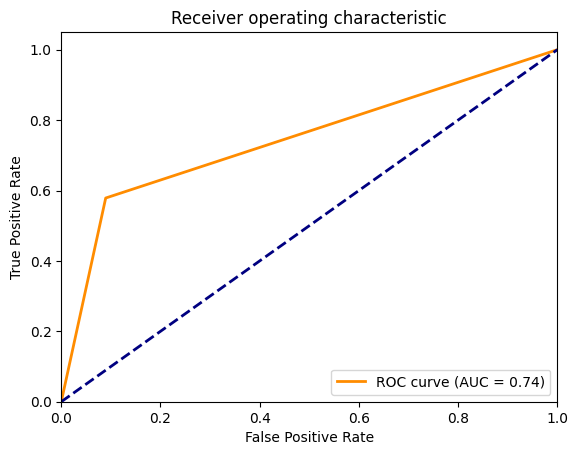

In [7]:
# Concatenate the two DataFrames along the rows
df_concat = pd.concat([df_caribbean_GT, df_caribbean_ChatGPT], axis=0, keys=['ground_truth', 'predicted'])
# Create a column with predicted probabilities based on which DataFrame the label came from
df_concat = df_concat.assign(proba=np.nan)
df_concat.loc[('ground_truth', slice(None)), 'proba'] = 0
df_concat.loc[('predicted', slice(None)), 'proba'] = 1

# Fill missing values with the most frequent value (mode)
df_concat = df_concat.fillna(df_concat.mode().iloc[0])

# Flatten the binary labels into a single array
y_true = df_concat.loc['ground_truth', :].values.flatten()
y_pred = df_concat.loc['predicted', :].values.flatten()

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

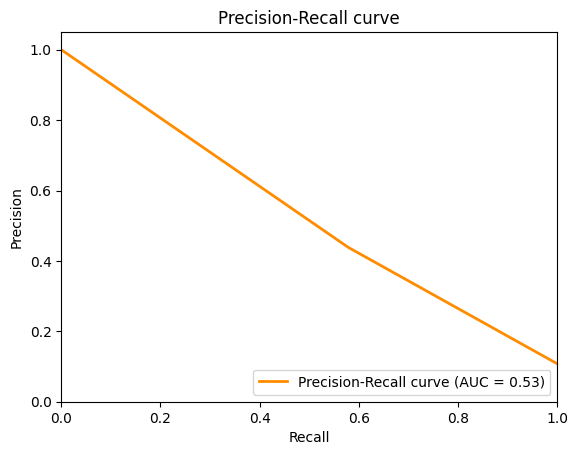

In [8]:
# Calculate the precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Calculate the AUC for the precision-recall curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % auc_score)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

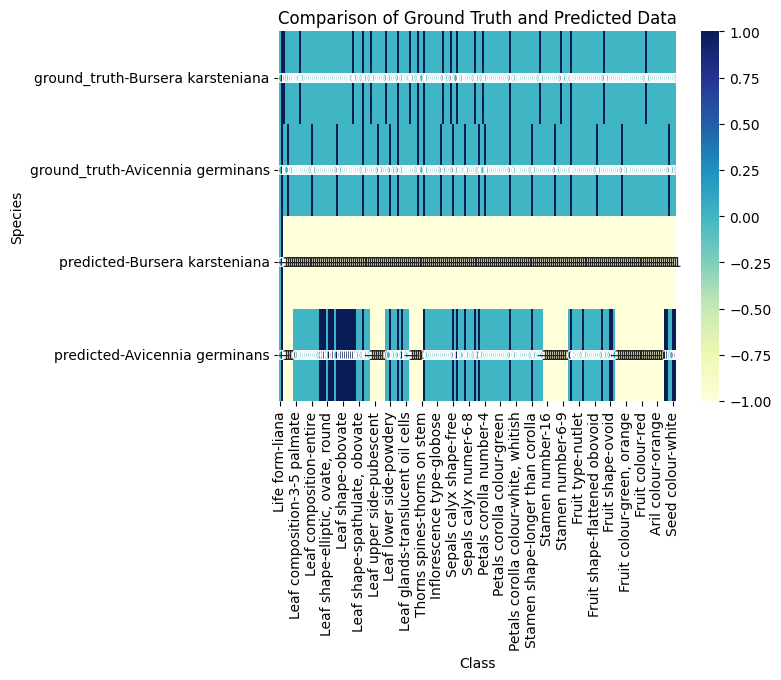

In [12]:
# Concatenate the two DataFrames along the rows
df_concat = pd.concat([df_caribbean_GT, df_caribbean_ChatGPT], axis=0, keys=['ground_truth', 'predicted'])


# Create a heatmap to compare the two dataframes
sns.heatmap(df_concat, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Comparison of Ground Truth and Predicted Data')
plt.xlabel('Class')
plt.ylabel('Species')
plt.show()

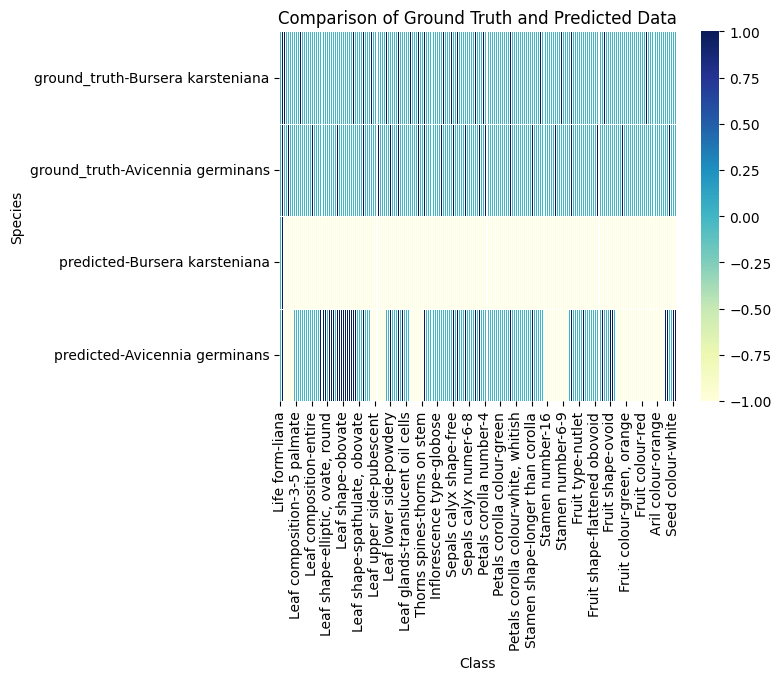

In [13]:

# Create a heatmap to compare the two dataframes
sns.heatmap(df_concat, annot=False, fmt='g', cmap='YlGnBu',
            square=False, linewidths=.5)
plt.title('Comparison of Ground Truth and Predicted Data')
plt.xlabel('Class')
plt.ylabel('Species')
plt.show()